# Classfication of address tags
In this notebook, we will try de classify address tags containing a keyword which will allow the AI to decides wether or not this address is the sender address.

Input data:
Data is generated with the file "text-classification-generator.py". It uses a list of 1849 european addresses, 38 different keywords to identify senders and 32 keywords to identify receivers. With these lists, it creates a new file named "generated.csv" composed with :
- a label : "sender_details" or "receiver_details"
- an address : text representing an address, with a keyword included in the address line in a random position
- a width : width of the bloc detected by the object detection AI
- a height : height of the bloc detected by the object detection AI

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import string
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import pickle

In [99]:
df = pd.read_csv('../utils/generated.csv', sep=';', encoding='utf-8')

In [100]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [101]:
def plot_scores_siamois(train) :
    accuracy_1 = train.history['output_addr_1_accuracy']
    accuracy_2 = train.history['output_addr_2_accuracy']
    
    val_accuracy_1 = train.history['val_output_addr_1_accuracy']
    val_accuracy_2 = train.history['val_output_addr_2_accuracy']
    
    epochs = range(len(accuracy_1))
    plt.plot(epochs, accuracy_1, 'b', label='Score apprentissage output 1')
    plt.plot(epochs, accuracy_2, 'darkblue', label='Score apprentissage output 2')
    plt.plot(epochs, val_accuracy_1, 'r', label='Score validation output 1')
    plt.plot(epochs, val_accuracy_2, 'darkred', label='Score validation output 2')
    plt.title('Scores')
    plt.legend()
    plt.show()

## Preprocessing

In [102]:
X = df.drop(["label", "width", "height"], 1)
y = df.label

C:\Users\sacha\AppData\Local\Temp\ipykernel_1264\2548596853.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop(["label", "width", "height"], 1)


In [103]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

In [104]:
X.text[0]

' 11 Belmont Road'

In [105]:
new_X = []
for i, sentence in enumerate(X.text):
    tmp_sentence = sentence.lower()
    tmp_sentence = tmp_sentence.replace('\n', '')
    tmp_sentence = tmp_sentence.translate(translator)
    new_X.append(tmp_sentence)

In [106]:
new_X[0]

' 11 belmont road'

In [107]:
X = new_X

In [108]:
top_words = 20000
tokenizer = Tokenizer(num_words=top_words, char_level=True)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

with open('../models/tokenizer_clf.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [109]:
np.max([len(i) for i in X])

130

In [110]:
max_words = 200
X = sequence.pad_sequences(X, maxlen=max_words, padding='post')

In [111]:
y = y.map({'sender_details': 0, 'receiver_details': 1, 'unknown': 2})
y = to_categorical(y)

In [112]:
X = X.reshape(int(X.shape[0]/2),2,X.shape[1])
y = y.reshape(int(y.shape[0]/2),2,y.shape[1])

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [114]:
X_train.shape

(1500, 2, 200)

In [115]:
X_train_A = np.array([X_train[i][0] for i in range(len(X_train))])
X_train_B = np.array([X_train[i][1] for i in range(len(X_train))])
X_test_A = np.array([X_test[i][0] for i in range(len(X_test))])
X_test_B = np.array([X_test[i][1] for i in range(len(X_test))])

y_train_A = np.array([y_train[i][0] for i in range(len(y_train))])
y_train_B = np.array([y_train[i][1] for i in range(len(y_train))])
y_test_A = np.array([y_test[i][0] for i in range(len(y_test))])
y_test_B = np.array([y_test[i][1] for i in range(len(y_test))])

In [116]:
def preprocessing(X,y = None,max_words = 200):
    with open('../models/tokenizer_clf.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    
    X_ = []
    for i, sentence in enumerate(X):
        tmp_sentence = sentence.lower()
        tmp_sentence = tmp_sentence.replace('\n', '')
        tmp_sentence = tmp_sentence.translate(translator)
        X_.append(tmp_sentence)
    X = X_.copy()
    
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=max_words, padding='post')

    X = X.reshape(int(X.shape[0]/2),2,X.shape[1])
    
    if y is not None:
        y = y.map({'sender_details': 0, 'receiver_details': 1, 'unknown': 2})
        y = to_categorical(y)
        y = y.reshape(int(y.shape[0]/2),2,y.shape[1])
        return X,y
    else :
        return X
    
   

In [117]:
def a_b_split(X,y):
    X_a = np.array([X[i][0] for i in range(len(X))])
    X_b = np.array([X[i][1] for i in range(len(X))])
    
    y_a = np.array([y[i][0] for i in range(len(y))])
    y_b = np.array([y[i][1] for i in range(len(y))])
    
    return X_a, X_b, y_a, y_b

## Training
### CNN

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Conv1D, MaxPool1D, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [119]:
X_train_B.shape

(1500, 200)

In [120]:
addr_1_input = Input(shape=(200,), name='input_addr_1')
txt_embed_1 = Embedding(3750,200,input_length=200)(addr_1_input)

addr_2_input = Input(shape=(200,), name='input_addr_2')
txt_embed_2 = Embedding(3750,200,input_length=200)(addr_2_input)

conv_1_1 = Conv1D(128,5, activation='relu')(txt_embed_1)
drop_1_1 = Dropout(0.3)(conv_1_1)
maxpool_1_1 = MaxPool1D()(drop_1_1)
conv_1_2 = Conv1D(64,3, activation='relu')(maxpool_1_1)
drop_1_5 = Dropout(0.5)(conv_1_2)
maxpool_1_5 = MaxPool1D()(drop_1_5)
conv_1_3 = Conv1D(32,3, activation='relu')(maxpool_1_5)
drop_1_2 = Dropout(0.5)(conv_1_3)
maxpool_1_2 = MaxPool1D()(drop_1_2)
conv_1_4 = Conv1D(16,3, activation='relu')(maxpool_1_2)

conv_2_1 = Conv1D(128,5, activation='relu')(txt_embed_2)
drop_2_1 = Dropout(0.3)(conv_2_1)
maxpool_2_1 = MaxPool1D()(drop_2_1)
conv_2_2 = Conv1D(64,3, activation='relu')(maxpool_2_1)
drop_2_5 = Dropout(0.5)(conv_2_2)
maxpool_2_5 = MaxPool1D()(drop_2_5)
conv_2_3 = Conv1D(32,3, activation='relu')(maxpool_2_5)
drop_2_2 = Dropout(0.5)(conv_2_3)
maxpool_2_2 = MaxPool1D()(drop_2_2)
conv_2_4 = Conv1D(16,3, activation='relu')(maxpool_2_2)

concat = Concatenate()([conv_1_4, conv_2_4])
flatten = Flatten()(concat)

dense_1 = Dense(3, activation='softmax', name='output_addr_1')(flatten)
dense_2 = Dense(3, activation='softmax', name='output_addr_2')(flatten)

model = Model([addr_1_input, addr_2_input], [dense_1, dense_2])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [121]:
len(X_train_B)

1500

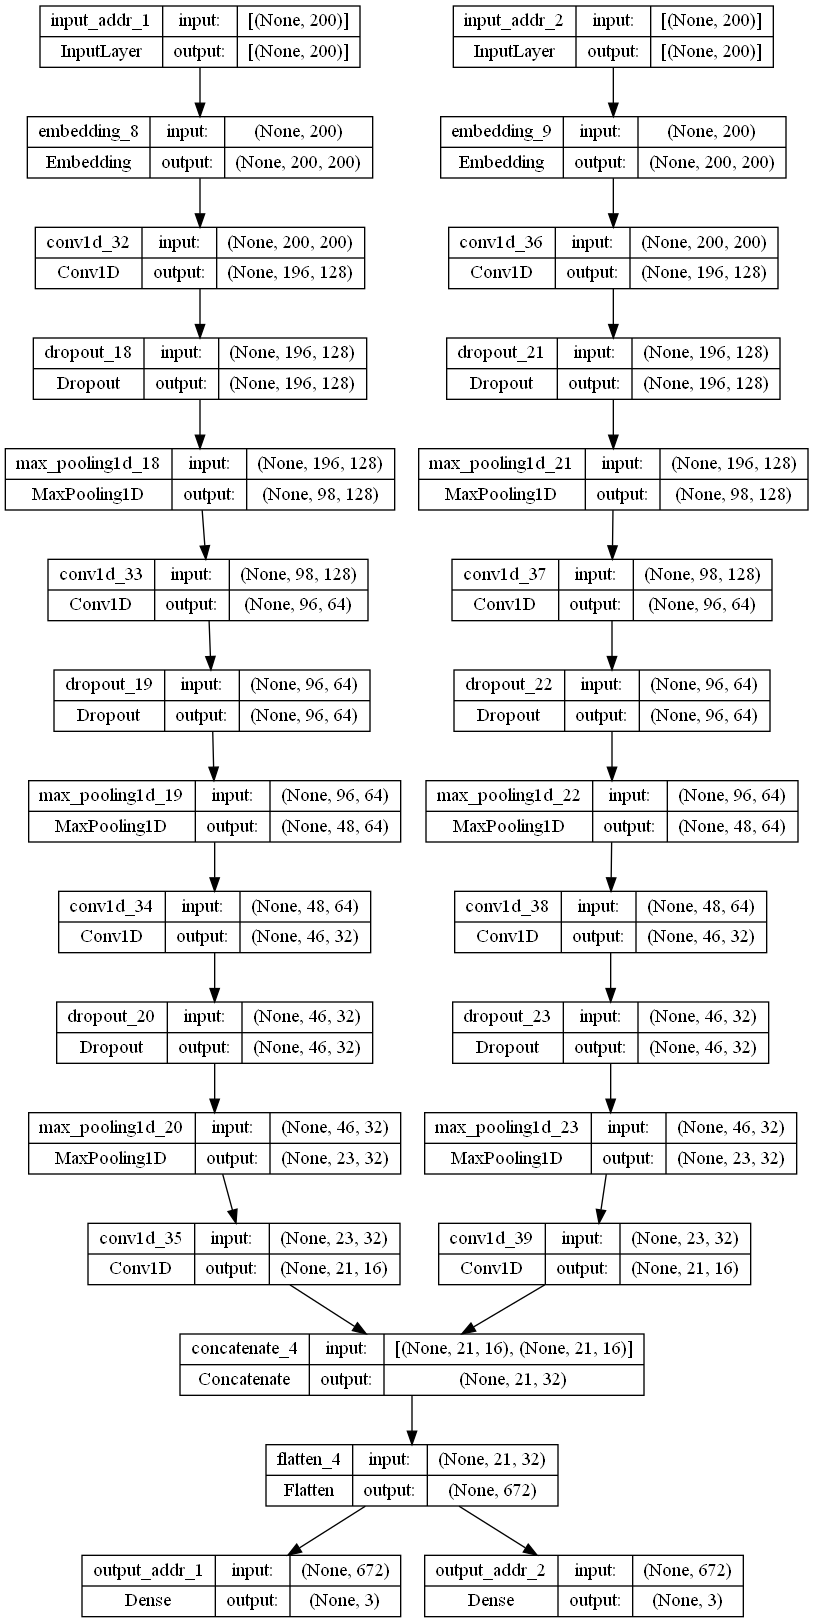

In [122]:
plot_model(model, show_shapes=True)

In [123]:
es = EarlyStopping("val_output_addr_1_accuracy", 0.001, 100, mode='max', restore_best_weights=True)

train = model.fit(
    {'input_addr_1': X_train_A, 'input_addr_2': X_train_B},
    {'output_addr_1': y_train_A, 'output_addr_2': y_train_B}, 
    validation_data=(
        {'input_addr_1': X_test_A, 'input_addr_2': X_test_B},
        {'output_addr_1': y_test_A, 'output_addr_2': y_test_B}), 
    epochs=1000, batch_size=256, callbacks=[es], verbose=2)

Epoch 1/1000
6/6 - 5s - loss: 2.2005 - output_addr_1_loss: 1.1001 - output_addr_2_loss: 1.1005 - output_addr_1_accuracy: 0.3493 - output_addr_2_accuracy: 0.3360 - val_loss: 2.1957 - val_output_addr_1_loss: 1.0980 - val_output_addr_2_loss: 1.0978 - val_output_addr_1_accuracy: 0.3480 - val_output_addr_2_accuracy: 0.3800 - 5s/epoch - 774ms/step
Epoch 2/1000
6/6 - 0s - loss: 2.1936 - output_addr_1_loss: 1.0969 - output_addr_2_loss: 1.0967 - output_addr_1_accuracy: 0.3520 - output_addr_2_accuracy: 0.3740 - val_loss: 2.1961 - val_output_addr_1_loss: 1.0988 - val_output_addr_2_loss: 1.0973 - val_output_addr_1_accuracy: 0.3360 - val_output_addr_2_accuracy: 0.3740 - 363ms/epoch - 61ms/step
Epoch 3/1000
6/6 - 0s - loss: 2.1894 - output_addr_1_loss: 1.0959 - output_addr_2_loss: 1.0935 - output_addr_1_accuracy: 0.3800 - output_addr_2_accuracy: 0.3700 - val_loss: 2.1921 - val_output_addr_1_loss: 1.0969 - val_output_addr_2_loss: 1.0952 - val_output_addr_1_accuracy: 0.3600 - val_output_addr_2_accurac

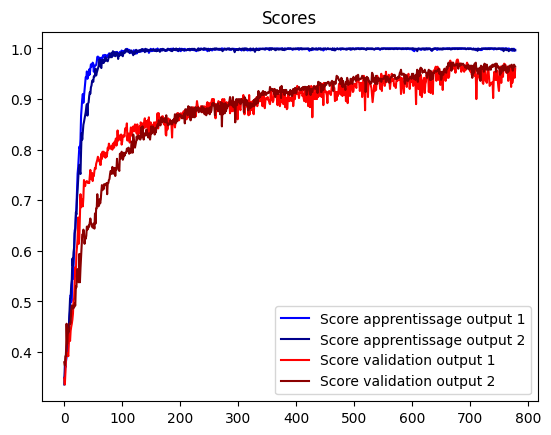

In [124]:
plot_scores_siamois(train)

In [125]:
model.save('./models/1_addr_clf.h5')

In [ ]:
X_test_A.shape

In [ ]:
y_pred = model.predict({'input_addr_1' : X_test_A, 'input_addr_2': X_test_B})

In [ ]:
y_pred_0 = (y_pred[0] > 0.5).astype(int)
y_pred_1 = (y_pred[1] > 0.5).astype(int)


In [ ]:
print(multilabel_confusion_matrix(y_test_A, y_pred_0))
print(classification_report(y_test_A,y_pred_0))

In [ ]:
print(multilabel_confusion_matrix(y_test_B, y_pred_1))
print(classification_report(y_test_B,y_pred_1))

## Test with custom data

In [ ]:
df_test = pd.read_csv('./generated-data/generated-t.csv', ';')

X = df_test.text
y = df_test.label

X,y = preprocessing(X,y)
X_a, X_b, y_a, y_b = a_b_split(X,y)

In [ ]:
y_cnn = model.predict({'input_addr_1' : X_a, 'input_addr_2': X_b})

In [ ]:
(y_cnn[0]>0.8).astype(int) - y_a.astype(int)

In [ ]:
(y_cnn[1]>0.8).astype(int) - y_b.astype(int)

## Conclusion

As the classification AI works very well with keywords (like a regexp-based algorithm), it can happens that no key words has been found with the OCR AI or with the bloc detection AI. We must take in account that only 4 or 5 blocs will be detected, and so, in a new version, this program will have to classifies multiple classes and concludes which one is the sender and which one is the receiver. It could be interesting to create a new AI to classify wether the block is an address block or not. After this, we'll have to deal with only to blocs : the **sender** and the **receiver** ones. At this point, we could predict the class of just one block and then conclude that the second is the non found class.  

## In real situation

With real data 

In [151]:
blocks_with_addresses = [
    "Service courrier GeoPost 9 rue Maurice from Mallet 92130 Issy Les Moulineaux ",
    "Perfect Barcode Ltd 123 Straightandnarrow Street Smethwick West midlands B66 1 BY CB England"
]

blocks_with_addresses = preprocessing(blocks_with_addresses)[0]
addr_a, addr_b = np.array(blocks_with_addresses[0]), np.array(blocks_with_addresses[1])

addr_a = addr_a.reshape(1,200)
addr_b = addr_b.reshape(1,200)

pred = model.predict({'input_addr_1' : addr_a, 'input_addr_2': addr_b})

classes = ['sender', 'receiver', 'unknown']

print(classes[np.argmax(pred[0])], pred[0][0][np.argmax(pred[0])], pred[0][0])
print(classes[np.argmax(pred[1])], pred[1][0][np.argmax(pred[1])], pred[1][0])

1/1 [==============================] - 0s 39ms/step
sender 0.6174636 [0.6174636  0.05010425 0.33243215]
sender 0.9889319 [9.8893189e-01 1.1044186e-02 2.3970204e-05]
